In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
batch_size = 50
img_height = 300
img_width = 300

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
#loading the dataset with an 80-20 split for training and validation.

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Praktikum Pola/rice leaf diseases dataset/',
    validation_split=0.2,
    subset="training",
    seed=42,  # Seed is used for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 489 files belonging to 3 classes.
Using 392 files for training.


In [7]:
# Extracting class names from the dataset for use in labeling and visualization

class_names = training_ds.class_names
class_names

['Bacterialblight', 'Brownspot', 'Leafsmut']

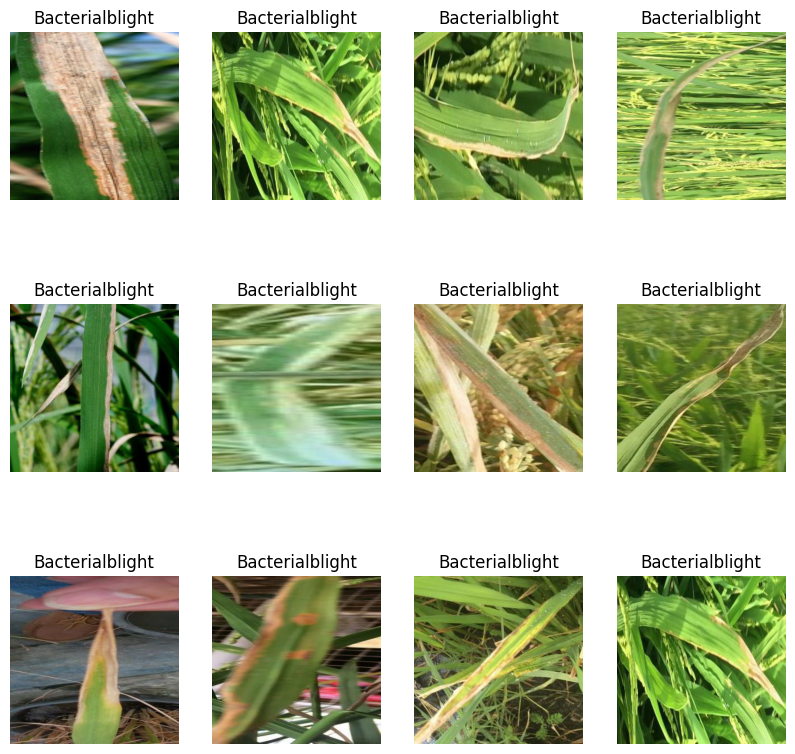

In [8]:
# This section visualizes a few images to understand the dataset better.

plt.figure(figsize=(10, 10))  # Setting the figure size for the plot
for images, labels in training_ds.take(1):  # Taking one batch of images for display
    for i in range(12):  # Displaying the first 12 images in the batch
        ax = plt.subplot(3, 4, i + 1)  # Arranging images in a 3x4 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Displaying the image
        plt.title(class_names[labels[i]])  # Setting the title as the class name
        plt.axis('off')  # Hiding the axis for a cleaner look
        plt.grid(False)  # Disabling grid lines
plt.show()  # Showing the plot with images

In [9]:
# Data augmentation is applied to the training dataset to make the model more robust.

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    layers.RandomRotation(0.2),  # Randomly rotate images by up to 20%
    layers.RandomZoom(0.2),  # Randomly zoom into images by up to 20%
    layers.RandomContrast(0.2)  # Randomly adjust contrast by up to 20%
])

In [10]:
# Applying data augmentation to the training dataset

training_ds = training_ds.map(lambda x, y: (data_augmentation(x), y))

In [12]:
# Loading and Preprocessing the Validation Dataset
# The validation dataset is loaded similarly but without data augmentation.

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Praktikum Pola/rice leaf diseases dataset/',
    validation_split=0.2,
    subset="validation",
    seed=42,  # Ensuring reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 612 files belonging to 3 classes.
Using 122 files for validation.


In [13]:
# A Sequential model is built with several convolutional layers, followed by dense layers.

model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),  # Input layer with the specified image shape
    layers.Rescaling(1./255),  # Rescaling pixel values to the range [0, 1]
    layers.Conv2D(32, 3, activation='relu'),  # First convolutional layer with 32 filters and ReLU activation
    layers.MaxPooling2D(),  # Max pooling layer to reduce spatial dimensions
    layers.Conv2D(64, 3, activation='relu'),  # Second convolutional layer with 64 filters
    layers.MaxPooling2D(),  # Max pooling layer
    layers.Conv2D(128, 3, activation='relu'),  # Third convolutional layer with 128 filters
    layers.MaxPooling2D(),  # Max pooling layer
    layers.Conv2D(256, 3, activation='relu'),  # Fourth convolutional layer with 256 filters
    layers.MaxPooling2D(),  # Max pooling layer
    layers.Flatten(),  # Flattening the output from convolutional layers to feed into dense layers
    layers.Dense(128, activation='relu'),  # Dense layer with 128 units and ReLU activation
    layers.Dropout(0.5),  # Dropout layer with 50% dropout rate to prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

In [14]:
# The model is compiled with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Sparse categorical crossentropy loss
    metrics=['accuracy']  # Accuracy as the evaluation metric
)

In [15]:
# The model summary provides an overview of the model architecture and parameters.

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,539 (33.48 MB)

 Trainable params: 8,777,539 (33.48 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Defining Callbacks for Training
# Learning rate scheduler and early stopping are used to improve training efficiency and prevent overfitting.

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
# The model is trained for a specified number of epochs with the training and validation datasets.

epochs = 20
history = model.fit(
    training_ds,  # Training dataset
    validation_data=validation_ds,  # Validation dataset
    epochs=epochs,  # Number of training epochs
    callbacks=[lr_scheduler, early_stopping]  # Callbacks for learning rate scheduling and early stopping
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 16s/step - accuracy: 0.7975 - loss: 0.3500 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 14s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 14s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 1.0000 - loss: 0.0000e+00 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8/8 ━━━━━━━━━━━━━━━━━━━━ 118s 15s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 153s 16s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 123s 15s/step - accura

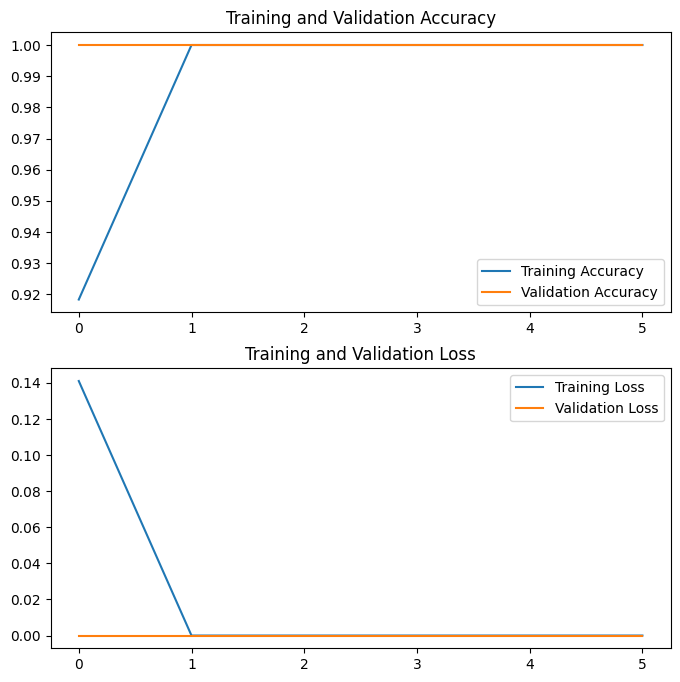

In [18]:
# The training and validation accuracy and loss are plotted to evaluate model performance.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))  # Setting the figure size for plots
plt.subplot(2, 1, 1)  # First subplot for accuracy
plt.plot(acc, label='Training Accuracy')  # Plotting training accuracy
plt.plot(val_acc, label='Validation Accuracy')  # Plotting validation accuracy
plt.legend(loc='lower right')  # Adding legend to the lower right
plt.title('Training and Validation Accuracy')  # Adding title

plt.subplot(2, 1, 2)  # Second subplot for loss
plt.plot(loss, label='Training Loss')  # Plotting training loss
plt.plot(val_loss, label='Validation Loss')  # Plotting validation loss
plt.legend(loc='upper right')  # Adding legend to the upper right
plt.title('Training and Validation Loss')  # Adding title
plt.show()  # Displaying the plots

In [19]:
# Displaying the Maximum Validation Accuracy
# The maximum validation accuracy is printed to assess the best model performance.

print("Maximum Validation Accuracy:", max(val_acc))

Maximum Validation Accuracy: 1.0


In [ ]:
# On the Validation Dataset
# The model's predictions are visualized alongside the actual labels, including the prediction confidence.
plt.figure(figsize=(20, 35))  # Setting the figure size for evaluation plots

for images, labels in validation_ds.take(1):  # Taking one batch from the validation dataset
    predictions = model.predict(images)  # Making predictions on the batch
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]  # Converting predictions to class names
    pred_confidences = [np.max(pred) for pred in predictions]  # Extracting the maximum confidence for each prediction

    # Displaying the first 20 predictions
    for i in range(18):  # Displaying the first 20 images
        ax = plt.subplot(6, 3, i + 1)  # Arranging in a 6x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Displaying the image
        plt.title(f'Prediction: {pred_labels[i]}\nConfidence: {pred_confidences[i]:.2f}\nActual: {class_names[labels[i]]}')  # Displaying predicted label, confidence, and actual label
        plt.axis('off')  # Hiding axis for a cleaner look
        plt.grid(False)  # Disabling grid lines

plt.show()  # Showing the evaluation plot